# Exploring the Iris dataset

This notebook explores the Iris dataset using visualization and **Principal Components Analysis (PCA)**, and compares **k-Means** and **Gaussian Mixture Model (GMM)** clustering using the **adjusted Rand score**.

<!-- 

this does make links when rendered to html, 
but when you click on one it opens in another tab in a distorted view...

## Contents

1. [Imports](#Imports)
1. [Get Data](#GetData)
1. [Visualize Data](#VisualizeData)
1. [Feature Scaling](#FeatureScaling)
1. [K-Means Clustering](#KMeansClustering)
1. [Principal Components Analysis (PCA)](#PCA)
1. [Gaussian Mixture Model (GMM)](#GMM)
1. [Comparing K-Means and GMM](#Comparing)
1. [Conclusion](#Conclusion)
-->

<a id='Imports'></a>

----------

## Imports

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
  # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Using TensorFlow backend.


In [209]:
# import some libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import time
from scipy.stats import kurtosis

from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import LabelEncoder

import keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.optimizers import Adam

# seaborn is a layer on top of matplotlib which has additional visualizations -
# just importing it changes the look of the standard matplotlib plots.
# the current version also shows some warnings which we'll disable.
import seaborn as sns
sns.set(style="white", color_codes=True)
import warnings
warnings.filterwarnings("ignore")

from keras_tqdm import TQDMCallback
from tqdm import tqdm
import gc
# show plots inline
%matplotlib inline

<a id='GetData'></a>

----

## Get Data

In [158]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [3]:
# get data and show some records
data = pd.read_csv('../data/Iris.csv')
data = data.drop('Id', axis=1) # get rid of the Id column - don't need it
data.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
113,5.7,2.5,5.0,2.0,Iris-virginica
105,7.6,3.0,6.6,2.1,Iris-virginica
67,5.8,2.7,4.1,1.0,Iris-versicolor
41,4.5,2.3,1.3,0.3,Iris-setosa
47,4.6,3.2,1.4,0.2,Iris-setosa


In [4]:
# split data into features (X) and labels (y)
X = data.iloc[:,0:4]
y = data.iloc[:,-1]
print(X.sample(5))
print(y.sample(5))

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
32             5.2           4.1            1.5           0.1
100            6.3           3.3            6.0           2.5
14             5.8           4.0            1.2           0.2
105            7.6           3.0            6.6           2.1
27             5.2           3.5            1.5           0.2
64     Iris-versicolor
28         Iris-setosa
95     Iris-versicolor
146     Iris-virginica
82     Iris-versicolor
Name: Species, dtype: object


In [5]:
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)

Y = pd.get_dummies(y1).values
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0) 

<a id='VisualizeData'></a>

----

## Visualize Data

For more visualizations see Ben Hamner's notebook - https://www.kaggle.com/benhamner/d/uciml/iris/python-data-visualizations - I borrowed a couple of things from there. 

In [6]:
# see how many samples we have of each species 
data["Species"].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: Species, dtype: int64

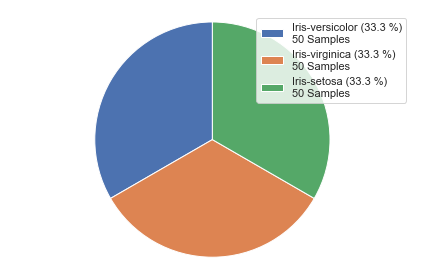

In [7]:
labels = ["Iris-versicolor (33.3 %)\n50 Samples", "Iris-virginica (33.3 %)\n50 Samples", "Iris-setosa (33.3 %)\n50 Samples"]
sizes = data["Species"].value_counts()
patches, texts = plt.pie(sizes, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()

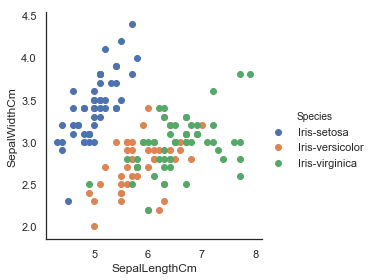

In [8]:
# use seaborn to make scatter plot showing species for each sample
sns.FacetGrid(data, hue="Species", size=4) \
   .map(plt.scatter, "SepalLengthCm", "SepalWidthCm") \
   .add_legend();

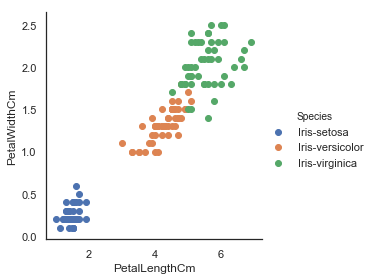

In [9]:
# do same for petals
sns.FacetGrid(data, hue="Species", size=4) \
   .map(plt.scatter, "PetalLengthCm", "PetalWidthCm") \
   .add_legend();

In [10]:
# note that the species are nearly linearly separable with petal size,
# but sepal sizes are more mixed.

# but a clustering algorithm might have a hard time realizing that there were
# three separate species, which we happen to know in advance - 
# usually if you're doing exploratory data analysis (EDA), you don't know this, 
# e.g. if you were looking for different groups of customers. 

# it might not matter too much though - e.g. the versicolor and virginica species
# seem to be very similar, so it might be just as well for your 
# purposes to lump them together.

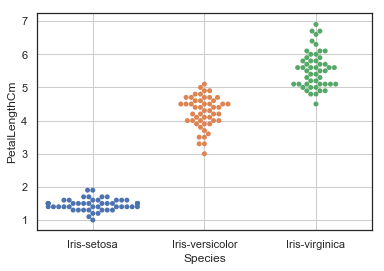

In [11]:
# show petal length distributions in a swarm plot - 
# just shows one dimension of the data, so not as useful as the previous plots
sns.swarmplot(x="Species", y="PetalLengthCm", data=data)
plt.grid()

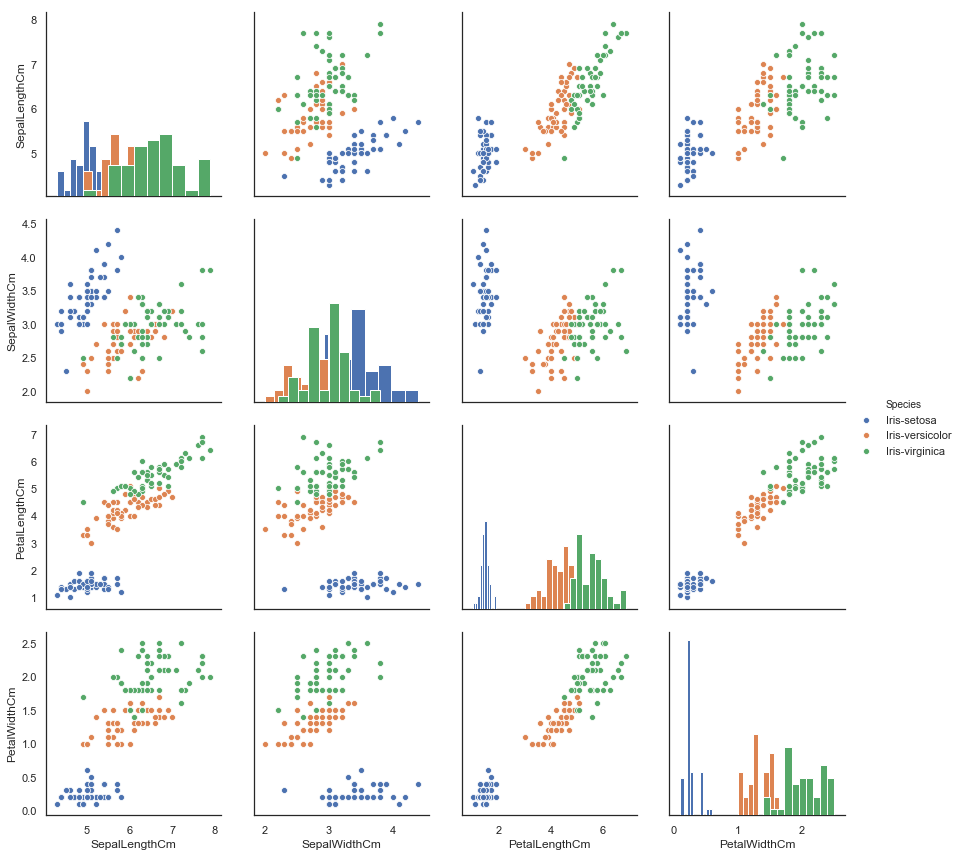

In [12]:
# make a scatter matrix showing each pair of features in the data.
# seaborn can show the species labels as different colors, but
# normally with EDA you wouldn't have that information. 
# note: the semicolon at the end just hides a line of text output.
sns.pairplot(data, hue="Species", diag_kind="hist", size=3);

In [13]:
# so again, this shows how similar versicolor and virginica are, at least with the given features.

# but there could be features that you didn't measure that would more clearly separate the species.

# it's the same for any unsupervised learning - you need to have the right features
# to separate the groups in the best way.

<a id='FeatureScaling'></a>

----

## Feature Scaling

In [14]:
# the data is unbalanced (eg sepallength ~4x petalwidth), so should do feature scaling,
# otherwise the larger features will dominate the others in clustering, etc.

from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

scaler.fit(X)
X_scaled_array = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns = X.columns)

scaler.fit(X_train)
X_train_scaled_array = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns = X_train.columns)

scaler.fit(X_test)
X_test_scaled_array = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns = X_test.columns)

X_scaled.sample(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
31,-0.537178,0.800654,-1.284407,-1.050031
146,0.553333,-1.281972,0.705893,0.922064
43,-1.021849,1.032057,-1.227541,-0.787085
116,0.795669,-0.124958,0.990221,0.790591
109,1.643844,1.263460,1.331416,1.710902


<a id='KMeansClustering'></a>

----

## K-Means Clustering

In [15]:
def kmeansTest(X_scaled):
    seed = 0
    k_means_times = []
    k_means_scores = []
    for k in range(1, 11):
        km = KMeans(n_clusters=k, random_state=seed)
        start = time.time()
        km.fit(X_scaled)
        end = time.time()
        k_means_times.append(end - start)
        y_cluster_kmeans = km.predict(X_scaled)
        score = metrics.v_measure_score(y, y_cluster_kmeans)
        k_means_scores.append(score)
    return k_means_scores, k_means_times

In [16]:
def gmmTest(X_scaled):
    seed = 0
    gmm_times = []
    gmm_scores = []
    for k in range(1, 11):
        gmm = GaussianMixture(n_components=k, random_state=seed)
        start = time.time()
        gmm.fit(X_scaled)
        end = time.time()
        gmm_times.append(end - start)
        y_cluster_gmm = gmm.predict(X_scaled)
        score = metrics.v_measure_score(y, y_cluster_gmm)
        gmm_scores.append(score)
    return gmm_scores, gmm_times

In [17]:
gmm_scores, gmm_times = gmmTest(X_scaled)
k_means_scores, k_means_times = kmeansTest(X_scaled)

In [18]:
gmm_scores[2]

0.8996935451597475

In [19]:
k_means_scores[2]

0.659486892724918

In [20]:
# try clustering on the 4d data and see if can reproduce the actual clusters.

# ie imagine we don't have the species labels on this data and wanted to
# divide the flowers into species. could set an arbitrary number of clusters
# and try dividing them up into similar clusters.

# we happen to know there are 3 species, so let's find 3 species and see
# if the predictions for each point matches the label in y.


nclusters = 3 # this is the k in kmeans
seed = 0

km = KMeans(n_clusters=nclusters, random_state=seed)
km.fit(X_scaled)

# predict the cluster for each data point
y_cluster_kmeans = km.predict(X_scaled)
y_cluster_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [21]:
# ordinarily, when you don't have the actual labels, you might use 
# silhouette analysis to determine a good number of clusters k to use. 

# i.e. you would just run that same code for different values of k and print the value for 
# the silhouette score. 

# let's see what that value is for the case we just did, k=3. 

> **Silhouette score** - a value near +1 indicates that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [22]:
score = metrics.silhouette_score(X_scaled, y_cluster_kmeans)
score

0.4589717867018717

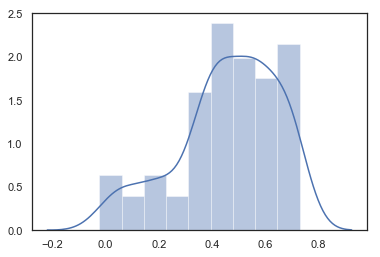

In [23]:
# note that this is the mean over all the samples - there might be some clusters 
# that are well separated and others that are closer together. 

# so let's look at the distribution of silhouette scores...

scores = metrics.silhouette_samples(X_scaled, y_cluster_kmeans)
sns.distplot(scores);

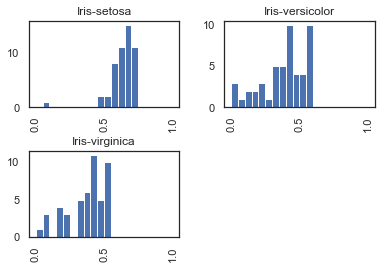

In [24]:
# can we add the species info to that plot?
# well, can plot them separately using pandas - 
df_scores = pd.DataFrame()
df_scores['SilhouetteScore'] = scores
df_scores['Species'] = data['Species']
df_scores.hist(by='Species', column='SilhouetteScore', range=(0,1.0), bins=20);

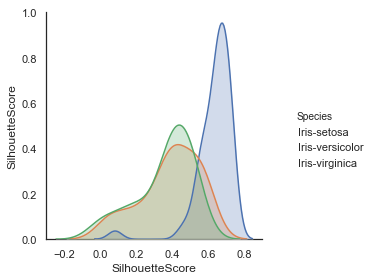

In [25]:
# so as expected, versicolor and virginica have lower silhouette scores than 
# the more separate setosas, because they are closer together.

# can we put them all on one histogram?
# yes, with a bit of a hack - it's not in seaborn yet - 
# see https://github.com/mwaskom/seaborn/issues/861
sns.pairplot(df_scores, hue="Species", size=4);

In [26]:
# so you can see that the blue species have higher silhouette scores
# (the legend doesn't show the colors though... so the pandas plot is more useful). 

# note that if we used the best mean silhouette score to try to find the best
# number of clusters k, we'd end up with 2 clusters, because the mean silhouette 
# score in that case would be largest, since the clusters would be better separated. 

# but, that's using k-means - gmm might give better results...

<a id='PCA'></a>

----

## Principal Component Analysis (PCA)

In [27]:
# so that was clustering on the orginal 4d data.

# if you have a lot of features it can be helpful to do some feature reduction
# to avoid the curse of dimensionality (i.e. needing exponentially more data
# to do accurate predictions as the number of features grows).

# you can do this with Principal Component Analysis (PCA), which remaps the data
# to a new (smaller) coordinate system which tries to account for the
# most information possible.

# you can *also* use PCA to visualize the data by reducing the 
# features to 2 dimensions and making a scatterplot. 
# it kind of mashes the data down into 2d, so can lose 
# information - but in this case it's just going from 4d to 2d, 
# so not losing too much info. 

# so let's just use it to visualize the data...

In [194]:
# here, we're gonna try to find the best number of components...
all_pca = PCA(random_state=seed)
start = time.time()
all_pca.fit(X_scaled)
end = time.time()

In [195]:
print(end - start)

0.0019762516021728516


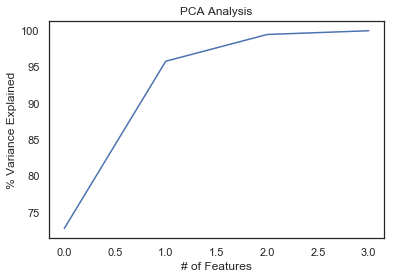

In [29]:
plt.figure()
plt.plot(np.cumsum(all_pca.explained_variance_ratio_) * 100)
plt.xlabel('# of Features')
plt.ylabel('% Variance Explained') #for each component
plt.title('PCA Analysis')
plt.show()

In [198]:
# mash the data down into 2 dimensions
ndimensions = 2

pca = PCA(n_components=ndimensions, random_state=seed)
start = time.time()
pca.fit(X_scaled)
end = time.time()
print(end - start)
X_pca_array = pca.transform(X_scaled)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2']) # PC=principal component
X_pca.sample(5)

0.001962900161743164


,PC1,PC2
23,-1.820412,0.106751
86,1.049413,0.522197
84,0.221417,-0.280848
104,1.867891,0.291193
56,0.748715,0.778699


In [31]:
# so that gives us new 2d coordinates for each data point.

# at this point, if you don't have labelled data,
# you can add the k-means cluster ids to this table and make a
# colored scatterplot. 

# we do actually have labels for the data points, but let's imagine
# we don't, and use the predicted labels to see what the predictions look like.

# first, convert species to an arbitrary number
y_id_array = pd.Categorical(data['Species']).codes

df_plot = X_pca.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['SpeciesId'] = y_id_array # also add actual labels so we can use it in later plots
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,SpeciesId
64,-0.037258,-0.432795,0,1
51,0.732481,0.598636,2,1
130,2.435497,0.246654,2,2
53,0.397307,-1.758169,0,1
94,0.282944,-0.853951,0,1


In [32]:
# so now we can make a 2d scatterplot of the clusters
# first define a plot fn

def plotData(df, groupby, title, ax1, ax2):
    "make a scatterplot of the first two principal components of the data, colored by the groupby field"
    
    # make a figure with just one subplot.
    # you can specify multiple subplots in a figure, 
    # in which case ax would be an array of axes,
    # but in this case it'll just be a single axis object.
    fig, ax = plt.subplots(figsize = (7,7))

    # color map
    cmap = mpl.cm.get_cmap('prism')

    # we can use pandas to plot each cluster on the same graph.
    # see http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
    for i, cluster in df.groupby(groupby):
        print(cmap(i/(nclusters-1)))
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(nclusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    plt.xlabel(ax1)
    plt.ylabel(ax2)

    plt.title(title)

(1.0, 0.0, -0.0, 1.0)
(1.0, 0.8450918051812084, 0.0, 1.0)
(0.32950712519534225, 0.99825489314128, 0.0, 1.0)


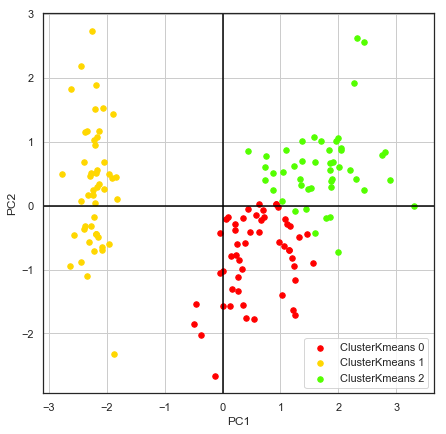

In [33]:
# plot the clusters each datapoint was assigned to
plotData(df_plot, 'ClusterKmeans', "", "PC1", "PC2")

(1.0, 0.0, -0.0, 1.0)
(1.0, 0.8450918051812084, 0.0, 1.0)
(0.32950712519534225, 0.99825489314128, 0.0, 1.0)


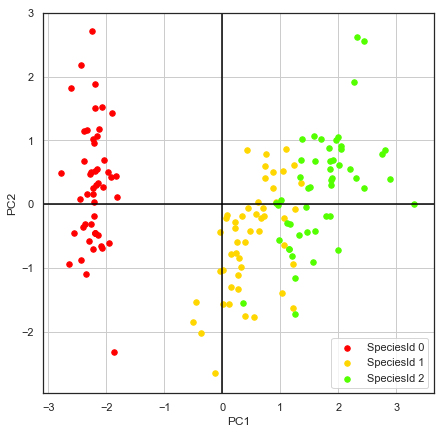

In [34]:
# so those are the *predicted* labels - what about the *actual* labels?
plotData(df_plot, 'SpeciesId', "", "PC1", "PC2")

In [35]:
# so the k-means clustering *did not* find the correct clusterings!

# q. so what do these dimensions mean?

# they're the principal components, which pick out the directions 
# of maximal variation in the original data.
# PC1 finds the most variation, PC2 the second-most. 
# the rest of the data is basically thrown away when the data is reduced down to 2d.

# q. if these principal components represent some latent (hidden) features, what would those be? 

# maybe size (area) of the petals and sepals? 

## ICA Analysis

<a id='GMM'></a>

----

## Gaussian Mixture Model (GMM) Clustering

In [36]:
# now let's try GMM clustering, which tries to fit normally-distributed clusters, 
# and might be the case when measuring things like petal and sepal sizes...

gmm = GaussianMixture(n_components=nclusters, random_state=seed)
gmm.fit(X_scaled)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_scaled)
y_cluster_gmm

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

(1.0, 0.0, -0.0, 1.0)
(1.0, 0.8450918051812084, 0.0, 1.0)
(0.32950712519534225, 0.99825489314128, 0.0, 1.0)


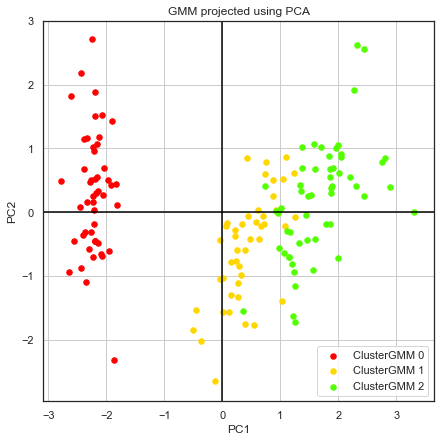

In [37]:
# add the GMM clusters to our data table and plot them
df_plot['ClusterGMM'] = y_cluster_gmm
plotData(df_plot, 'ClusterGMM', "GMM projected using PCA", "PC1", "PC2")

In [38]:
# the GMM did much better at finding the actual species clusters! how did it do that? 

# GMM tries to fit normally distributed clusters, which is probably the case with this data,
# so it fit it better. k-means is biased towards spherically distributed clusters.

In [39]:
pca_loss = ((X_scaled - pca.inverse_transform(pca.transform(X_scaled))) ** 2).mean().mean()
pca_loss

0.04199024638518027

In [181]:
print(kurtosis(pca.components_, axis=1))

[-0.67674155 -1.08174288]


In [41]:
print(all_pca.singular_values_)

[20.89551896 11.75513248  4.7013819   1.75816839]


In [42]:
pca_gmm_scores, pca_gmm_times = gmmTest(pca.transform(X_scaled))

In [43]:
pca_kmeans_scores, pca_kmeans_times = kmeansTest(pca.transform(X_scaled))

In [199]:
ica = FastICA(n_components=2, random_state=seed)

In [200]:
start = time.time()
ica.fit(X_scaled)
end = time.time()
print(end - start)

0.0029914379119873047


In [46]:
X_ica_array = ica.transform(X_scaled)
X_ica = pd.DataFrame(X_ica_array, columns=['PC1','PC2']) # PC=principal component
X_ica.sample(5)

,PC1,PC2
3,0.111976,0.044912
72,-0.055825,0.082123
63,-0.033726,0.017010
53,-0.013574,0.150158
114,-0.068648,0.040301


In [47]:
y_id_array = pd.Categorical(data['Species']).codes

df_plot = X_ica.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['SpeciesId'] = y_id_array # also add actual labels so we can use it in later plots
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,SpeciesId
76,-0.059729,0.009202,2,1
16,0.100675,-0.132514,1,0
105,-0.134155,-0.062244,2,2
46,0.110333,-0.101955,1,0
70,-0.036550,-0.032933,2,1


(1.0, 0.0, -0.0, 1.0)
(1.0, 0.8450918051812084, 0.0, 1.0)
(0.32950712519534225, 0.99825489314128, 0.0, 1.0)


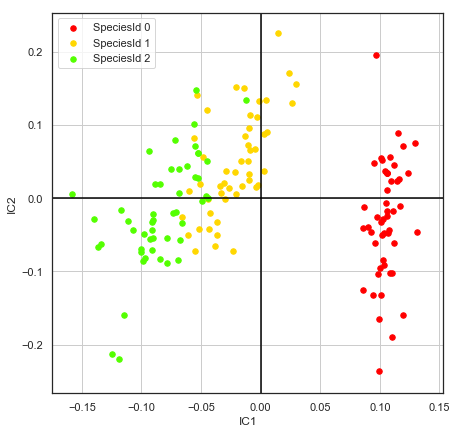

In [48]:
plotData(df_plot, 'SpeciesId' ,"", "IC1", "IC2")

In [49]:
ica_gmm_scores, ica_gmm_times = gmmTest(ica.transform(X_scaled))

In [50]:
ica_kmeans_scores, ica_kmeans_times = kmeansTest(ica.transform(X_scaled))

In [51]:
ica_loss = ((X_scaled - ica.inverse_transform(ica.transform(X_scaled))) ** 2).mean().mean()
ica_loss

0.04199024638518027

In [182]:
print(kurtosis(ica.components_, axis=1))

[-0.67075488 -1.069148  ]


In [183]:
print(kurtosis(pca.components_, axis=1))

[-0.67674155 -1.08174288]


In [54]:
X_pca_array = pca.transform(X_scaled)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2']) # PC=principal component

In [55]:
def get_best_rp(X_scaled):
    best_rp = None
    best_rp_loss = float("inf")
    loss_scores = []
    times = []
    for i in range(0, 1000):
        rp = GaussianRandomProjection(n_components=2)
        start = time.time()
        rp.fit(X_scaled)
        end = time.time()
        times.append(end - start)
        rp_reconstruct = np.dot(rp.transform(X_scaled), rp.components_) + X_scaled.mean().values
        rp_loss = ((X_scaled - rp_reconstruct ** 2)).mean().mean()
        loss_scores.append(abs(rp_loss))
        if abs(rp_loss) < best_rp_loss:
            best_rp_loss = abs(rp_loss)
            best_rp = rp
    
    return best_rp, best_rp_loss, loss_scores, times

In [56]:
best_rp, best_rp_loss, loss_scores, rp_times = get_best_rp(X_scaled)

In [57]:
np.array(rp_times).mean()

0.0008047637939453125

Text(0,0.5,'Frequency')

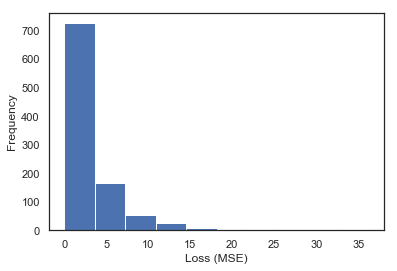

In [58]:
plt.hist(loss_scores)
plt.xlabel("Loss (MSE)")
plt.ylabel("Frequency")

In [59]:
best_rp

GaussianRandomProjection(eps=0.1, n_components=2, random_state=None)

In [60]:
best_rp_loss

0.014914155058584677

In [61]:
X_rp_array = best_rp.transform(X_scaled)
X_rp = pd.DataFrame(X_rp_array, columns=['PC1','PC2']) # PC=principal component
X_rp.sample(5)

,PC1,PC2
77,-0.055833,-0.380925
86,0.060604,-0.328196
117,-0.228153,-0.668701
67,-0.045729,-0.082748
112,-0.230601,-0.465775


In [62]:
y_id_array = pd.Categorical(data['Species']).codes

df_plot = X_rp.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['SpeciesId'] = y_id_array # also add actual labels so we can use it in later plots
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,SpeciesId
149,-0.459730,-0.162551,0,2
28,0.537458,0.491560,1,0
4,0.435177,0.589864,1,0
64,-0.076607,0.049103,0,1
71,0.044634,-0.149725,0,1


(1.0, 0.0, -0.0, 1.0)
(1.0, 0.8450918051812084, 0.0, 1.0)
(0.32950712519534225, 0.99825489314128, 0.0, 1.0)


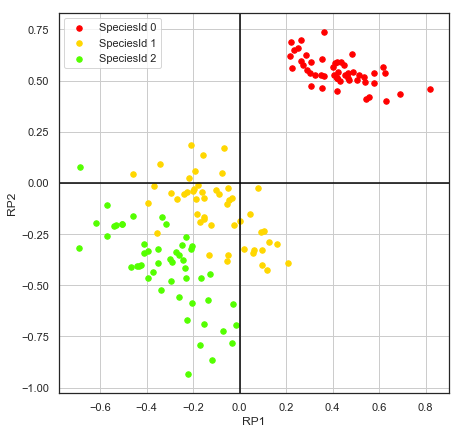

In [63]:
plotData(df_plot, 'SpeciesId' ,"", "RP1", "RP2")

In [64]:
rp_gmm_scores, rp_gmm_times = gmmTest(best_rp.transform(X_scaled))

In [65]:
rp_kmeans_scores, rp_kmeans_times = kmeansTest(best_rp.transform(X_scaled))

In [66]:
rp_kmeans_scores

[-9.095116925863002e-16,
 0.7336804366512104,
 0.6401804206005287,
 0.7372776740620359,
 0.7984720520378902,
 0.726487427704411,
 0.6752894821905022,
 0.6442845657692094,
 0.6355207473037278,
 0.6003762942669603]

oh no
35.28318810462952


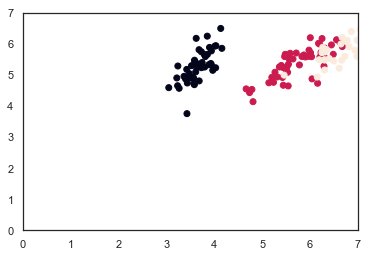

Autoencoder Loss :  0.5373438984155655


In [201]:
def getAutoencoder(input_dim):
    encoding_dim = 2
    # this is our input placeholder
    input_img = Input(shape=(input_dim,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu',
                   kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=1, seed=None),
                    bias_initializer=keras.initializers.RandomUniform(minval=0, maxval=1, seed=None))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(input_dim, activation='relu',
                   kernel_initializer=keras.initializers.RandomUniform(minval=0, maxval=1, seed=None),
                    bias_initializer=keras.initializers.RandomUniform(minval=0, maxval=1, seed=None))(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)

    # create a placeholder for an encoded (2-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    autoencoder.compile(loss='mean_squared_error', optimizer='adam')
    return autoencoder, encoder, decoder

autoencoder, encoder, decoder = getAutoencoder(4)
start = time.time()
history = autoencoder.fit(X_scaled, X_scaled,
                epochs=300,
                batch_size=15,
                shuffle=True,
                verbose=0,
#                 callbacks=[TQDMNotebookCallback()]
            )
end = time.time()
print("oh no")
print(end - start)

# Ploting encodings
encoded_dataset = encoder.predict(data[['SepalLengthCm', 'SepalWidthCm','PetalLengthCm', 'PetalWidthCm']])

plt.scatter(encoded_dataset[:,0], encoded_dataset[:,1], c=data['Species'].astype('category').cat.codes)
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.show()

# encode and decode some data points
# note that we take them from the *test* set
encoded_datapoints = encoder.predict(X_scaled)
decoded_datapoints = decoder.predict(encoded_datapoints)

print('Autoencoder Loss : ',history.history['loss'][-1])

In [193]:
history.on_train_begin

<bound method History.on_train_begin of <keras.callbacks.History object at 0x0000010E3B47F2E8>>

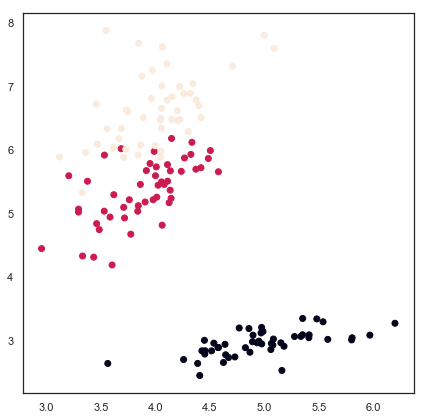

In [68]:
plt.figure(figsize = (7,7))
plt.scatter(encoded_dataset[:,0], encoded_dataset[:,1], c=data['Species'].astype('category').cat.codes)
plt.show()

In [69]:
autoencoder_gmm_scores, autoencoder_gmm_times = gmmTest(encoded_datapoints)

In [70]:
autoencoder_kmeans_scores, autoencoder_kmeans_times = kmeansTest(encoded_datapoints)

In [71]:
def getNeuralNetworkModel(data_shape):
    model = Sequential()

    model.add(Dense(10,input_shape=(data_shape,),activation='relu'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(6,activation='relu'))
    model.add(Dense(3,activation='softmax'))

    model.compile(Adam(lr=0.04),'categorical_crossentropy',metrics=['accuracy'])

    return model

In [72]:
NUM_TRIALS = 30

In [ ]:
reg_trials = []
for _ in range(0, NUM_TRIALS):
    gc.collect()
    model = getNeuralNetworkModel(4)
    start = time.time()
    model.fit(X_train,y_train,epochs=100, verbose=0)
    end = time.time()
    reg_trials.append(model.evaluate(X_test, y_test) + [end - start])

In [ ]:
np.mean(reg_trials, axis=0)

In [75]:
pca_transformed_train = pca.transform(X_train_scaled)
pca_transformed_test = pca.transform(X_test_scaled)
pca_trials = []
for _ in range(0, NUM_TRIALS):
    pca_nn_model = getNeuralNetworkModel(2)
    start = time.time()
    pca_nn_model.fit(pca_transformed_train,y_train,epochs=100, verbose=0)
    end = time.time()
    pca_trials.append(pca_nn_model.evaluate(pca_transformed_test, y_test) + [end - start])

30/30 [==============================] - 1s 24ms/step


In [76]:
np.mean(pca_trials, axis=0)

array([0.73416875, 0.73111111, 3.98165742])

In [77]:
ica_transformed_train = ica.transform(X_train_scaled)
ica_transformed_test = ica.transform(X_test_scaled)
ica_trials = []
for _ in range(0, NUM_TRIALS):
    ica_nn_model = getNeuralNetworkModel(2)
    start = time.time()
    ica_nn_model.fit(ica_transformed_train,y_train,epochs=100, verbose=0)
    end = time.time()
    ica_trials.append(ica_nn_model.evaluate(ica_transformed_test, y_test) + [end - start])

30/30 [==============================] - 1s 35ms/step


In [78]:
np.mean(ica_trials, axis=0)

array([0.57349398, 0.73666667, 5.01435237])

In [79]:
rp_transformed_train = best_rp.transform(X_train_scaled)
rp_transformed_test = best_rp.transform(X_test_scaled)
rp_trials = []
for _ in range(0, NUM_TRIALS):
    rp_nn_model = getNeuralNetworkModel(2)
    start = time.time()
    rp_nn_model.fit(rp_transformed_train,y_train,epochs=100, verbose=0)
    end = time.time()
    rp_trials.append(rp_nn_model.evaluate(rp_transformed_test, y_test) + [end - start])

30/30 [==============================] - 1s 48ms/step


In [80]:
np.mean(rp_trials, axis=0)

array([0.16648035, 0.89666666, 6.04757245])

In [81]:
rp_trials

[[0.19050025939941406, 0.8666666746139526, 5.511253118515015],
 [0.08553585410118103, 0.9666666388511658, 5.5302040576934814],
 [0.23311735689640045, 0.8666666746139526, 5.626446723937988],
 [0.46727147698402405, 0.5666666626930237, 5.569061756134033],
 [0.15092411637306213, 1.0, 5.643834352493286],
 [0.1196524128317833, 0.9333333373069763, 5.66779899597168],
 [0.09085862338542938, 0.9666666388511658, 5.6625471115112305],
 [0.11331591755151749, 0.9333333373069763, 5.7535624504089355],
 [0.21271966397762299, 0.8666666746139526, 5.733616590499878],
 [0.1596786379814148, 0.8999999761581421, 5.776507139205933],
 [0.24405448138713837, 0.8666666746139526, 5.918128728866577],
 [0.0669817253947258, 0.9666666388511658, 6.001903057098389],
 [0.06549932807683945, 1.0, 5.992762088775635],
 [0.2249247133731842, 0.8666666746139526, 6.050191164016724],
 [0.04606141149997711, 0.9666666388511658, 6.005905628204346],
 [0.5137048959732056, 0.7666666507720947, 6.509582757949829],
 [0.4522949755191803, 0.5

In [82]:
encoder_transformed_train = encoder.predict(X_train_scaled)
encoder_transformed_test = encoder.predict(X_test_scaled)
encoder_trials = []
for _ in range(0, NUM_TRIALS):
    encoder_nn_model = getNeuralNetworkModel(2)
    start = time.time()
    encoder_nn_model.fit(encoder_transformed_train,y_train,epochs=100, verbose=0)
    end = time.time()
    encoder_trials.append(encoder_nn_model.evaluate(encoder_transformed_test, y_test) + [end - start])

30/30 [==============================] - 2s 59ms/step


In [83]:
np.mean(encoder_trials, axis=0)

array([0.76946596, 0.72222222, 7.10663837])

In [84]:
km_transformed_train = km.transform(X_train_scaled)
km_transformed_test = km.transform(X_test_scaled)
km_trials = []
for _ in range(0, NUM_TRIALS):
    km_nn_model = getNeuralNetworkModel(3)
    start = time.time()
    km_nn_model.fit(km_transformed_train,y_train,epochs=100, verbose=0)
    end = time.time()
    km_trials.append(km_nn_model.evaluate(km_transformed_test, y_test) + [end - start])

30/30 [==============================] - 2s 71ms/step


In [85]:
np.mean(km_trials, axis=0)

array([0.5498971 , 0.75111111, 8.24238382])

In [94]:
gmm_transformed_train = gmm.predict_proba(X_train_scaled)
gmm_transformed_test = gmm.predict_proba(X_test_scaled)
gmm_trials = []
for _ in range(0, NUM_TRIALS):
    gmm_nn_model = getNeuralNetworkModel(3)
    start = time.time()
    gmm_nn_model.fit(gmm_transformed_train,y_train,epochs=100, verbose=0)
    end = time.time()
    gmm_trials.append(gmm_nn_model.evaluate(gmm_transformed_test, y_test) + [end - start])

30/30 [==============================] - 3s 98ms/step


In [95]:
np.mean(gmm_trials, axis=0)

array([ 0.09974345,  0.95777777, 11.01763239])

In [96]:
encoder_cluster_gmm = range(1,11)

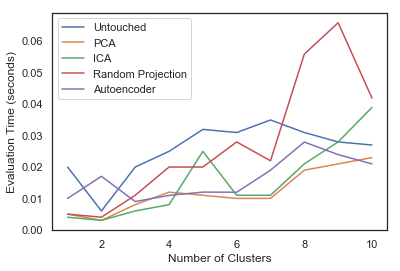

In [97]:
plt.plot(encoder_cluster_gmm, gmm_times)
plt.plot(encoder_cluster_gmm, pca_gmm_times)
plt.plot(encoder_cluster_gmm, ica_gmm_times)
plt.plot(encoder_cluster_gmm, rp_gmm_times)
plt.plot(encoder_cluster_gmm, autoencoder_gmm_times)
plt.xlabel("Number of Clusters")
plt.ylabel("Evaluation Time (seconds)")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

(0, 0.94)

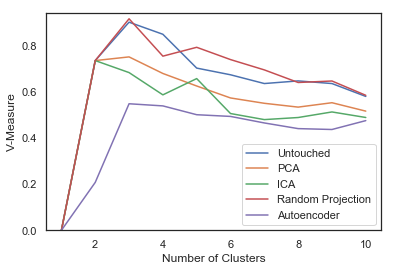

In [98]:
plt.plot(encoder_cluster_gmm, gmm_scores)
plt.plot(encoder_cluster_gmm, pca_gmm_scores)
plt.plot(encoder_cluster_gmm, ica_gmm_scores)
plt.plot(encoder_cluster_gmm, rp_gmm_scores)
plt.plot(encoder_cluster_gmm, autoencoder_gmm_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("V-Measure")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])
plt.ylim(0, .94)

In [99]:
gmm_scores[2]

0.8996935451597475

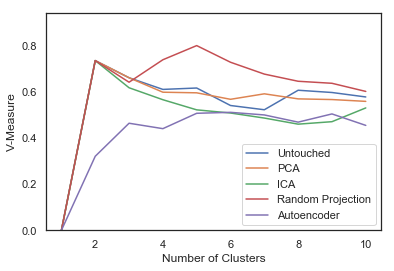

In [100]:
plt.plot(encoder_cluster_gmm, k_means_scores)
plt.plot(encoder_cluster_gmm, pca_kmeans_scores)
plt.plot(encoder_cluster_gmm, ica_kmeans_scores)
plt.plot(encoder_cluster_gmm, rp_kmeans_scores)
plt.plot(encoder_cluster_gmm, autoencoder_kmeans_scores)
plt.ylim(0, .94)
plt.xlabel("Number of Clusters")
plt.ylabel("V-Measure")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

In [143]:
np.argmax(k_means_scores)

1

In [144]:
k_means_scores[5]

0.5394888507793136

In [175]:
curious_km = KMeans(n_clusters=2, random_state=seed)
curious_km.fit(X_pca_array)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [176]:
y_id_array = pd.Categorical(data['Species']).codes
y_cluster_pca = curious_km.predict(X_pca_array)
df_plot = X_pca.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['ClusterKmeansPCA'] = y_cluster_pca

df_plot['SpeciesId'] = y_id_array # also add actual labels so we can use it in later plots
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,ClusterKmeansPCA,SpeciesId
110,1.365909,0.693948,2,1,2
99,0.252244,-0.595861,0,1,1
2,-2.367950,-0.318477,1,0,0
27,-2.168194,0.552016,1,0,0
89,0.275425,-1.329816,0,1,1


(1.0, 0.0, -0.0, 1.0)
(1.0, 0.8450918051812084, 0.0, 1.0)


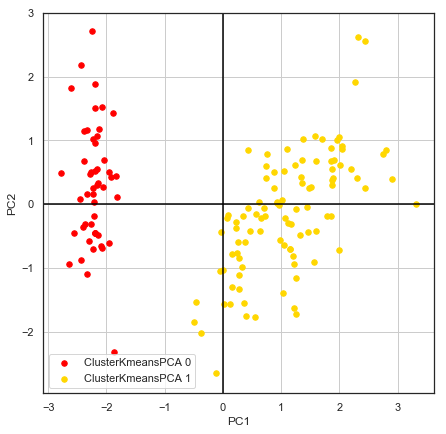

In [177]:
plotData(df_plot, "ClusterKmeansPCA", "", "PC1", "PC2")

In [178]:
curious_gmm = GaussianMixture(n_components=3, random_state=seed)
curious_gmm.fit(X_pca_array)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [179]:
y_id_array = pd.Categorical(data['Species']).codes
y_cluster_pca = curious_gmm.predict(X_pca_array)
df_plot = X_pca.copy()
df_plot['ClusterKmeans'] = y_cluster_kmeans
df_plot['ClusterGMMPCA'] = y_cluster_pca

df_plot['SpeciesId'] = y_id_array # also add actual labels so we can use it in later plots
df_plot.sample(5)

,PC1,PC2,ClusterKmeans,ClusterGMMPCA,SpeciesId
133,1.111272,-0.295986,0,1,2
42,-2.557834,-0.453816,1,0,0
59,0.004968,-1.029401,0,1,1
84,0.221417,-0.280848,0,1,1
130,2.435497,0.246654,2,2,2


(1.0, 0.0, -0.0, 1.0)
(1.0, 0.8450918051812084, 0.0, 1.0)
(0.32950712519534225, 0.99825489314128, 0.0, 1.0)


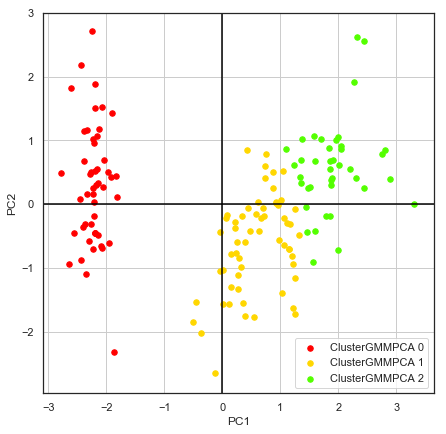

In [180]:
plotData(df_plot, "ClusterGMMPCA", "", "PC1", "PC2")

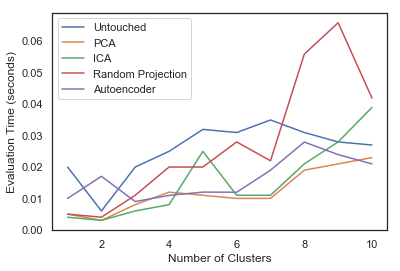

In [191]:
plt.plot(encoder_cluster_gmm, gmm_times)
plt.plot(encoder_cluster_gmm, pca_gmm_times)
plt.plot(encoder_cluster_gmm, ica_gmm_times)
plt.plot(encoder_cluster_gmm, rp_gmm_times)
plt.plot(encoder_cluster_gmm, autoencoder_gmm_times)
plt.xlabel("Number of Clusters")
plt.ylabel("Evaluation Time (seconds)")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

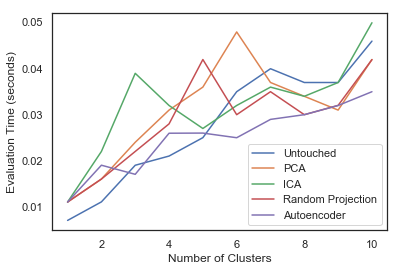

In [192]:
plt.plot(encoder_cluster_gmm, k_means_times)
plt.plot(encoder_cluster_gmm, pca_kmeans_times)
plt.plot(encoder_cluster_gmm, ica_kmeans_times)
plt.plot(encoder_cluster_gmm, rp_kmeans_times)
plt.plot(encoder_cluster_gmm, autoencoder_kmeans_times)
plt.xlabel("Number of Clusters")
plt.ylabel("Evaluation Time (seconds)")
plt.legend(["Untouched", "PCA", "ICA", "Random Projection", "Autoencoder"])

In [214]:
getNeuralNetworkModel(2).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1285 (Dense)           (None, 10)                30        
_________________________________________________________________
dense_1286 (Dense)           (None, 8)                 88        
_________________________________________________________________
dense_1287 (Dense)           (None, 6)                 54        
_________________________________________________________________
dense_1288 (Dense)           (None, 3)                 21        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
